# Grade: /100 pts

# Assignment 04: Confidence Intervals & The Bootstrap

Once you are finished, ensure to complete the following steps.
1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.
2.  Fix any errors which result from this.
3.  Repeat steps 1. and 2. until your notebook runs without errors.
4.  Submit your completed notebook to OWL by the deadline.

In [1]:
# Add the necessary imports for this homework 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
import sklearn.linear_model
from sklearn.metrics import r2_score
from scipy.stats import t

### Question 1: /10pts 
In this question, you will construct a confidence interval for the sample mean, not using the normal distribution, but the t-distribution (see end of lecture 4.3), which is more accurate for small sample sizes.  

The $100(1-\alpha)\%$ confidence interval is 

$$ \bar{x} \pm  t_{1-\alpha/2, n-1} \dfrac{\hat{\sigma}}{\sqrt{n}} $$

Where $ t_{1-\alpha/2, n-1}$ is the appropiorate quantile of a Student's t distribution with $n-1$ degrees of freedom.  
Write a function called `confidence_interval` which takes as it's argument an array of data called `data` and returns two things:

* An estimated mean of `data`, and 

* The lower and upper bounds of the 95% confidence interval for the mean of `data`.  Ensure these are returned in a numpy array of shape (2,)

To get the appropirate quantiles for the t-distribution, you can use `scipy.stats.t`, which implements some statistical functions for the t-distribution.  Take a look at the documentation for `scipy.stats.t`, especially the `ppf` method.

Here is the documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html


In [2]:
def confidence_interval(data):

    # Note, np.std divides by n and not n-1
    # Force it to apply the correct formula by ussing ddof=1
    # Alternaively, you can use scipy.stats.sem to compute
    #The standard error
    estimated_mean = np.mean(data)
    
    sig_hat = np.std(data, ddof=1)
    
    quantile = t.ppf(1-0.05/2, len(data)-1)
    
    lower_bound = estimated_mean - quantile * sig_hat / np.sqrt(len(data))
    upper_bound = estimated_mean + quantile * sig_hat / np.sqrt(len(data))
    bounds = np.array([lower_bound, upper_bound])
    return estimated_mean, bounds

### Question 2: /15pts

The "95% confidence interval" is named so because the long term relative frequency of these estimators containing the true estimand is 95%.  That is to say **if I construct 100 95% confidence intervals for the sample mean again and again from the same data generating mechanism, 95 of these intervals I construct will contain the true population mean**.

Write a function called `ci_simulation` that runs some simulations to show this is the case.  From a standard normal distirbution, sample 25 observations and construct a confidence interval.  Do this 20 times and plot the intervals using `matplotlib.pyplot.errorbar`.  Color the bar red if the confidence interval does not capture the true mean and blue if it does.  If you are unfamilliar with `matplotlib.pyplot.errorbar`, I highly suggest reading Matplotlib's excellent documentation which has some examples at the bottom of the webpage.

If you are unfamilliar with how to sample random numbers, I suggest you look at `numpy.random.normal`.  Try searching for the documentation for that function yourself if you need to.

Here is the documentation for `matplotlib.pyplot.errorbar`: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html

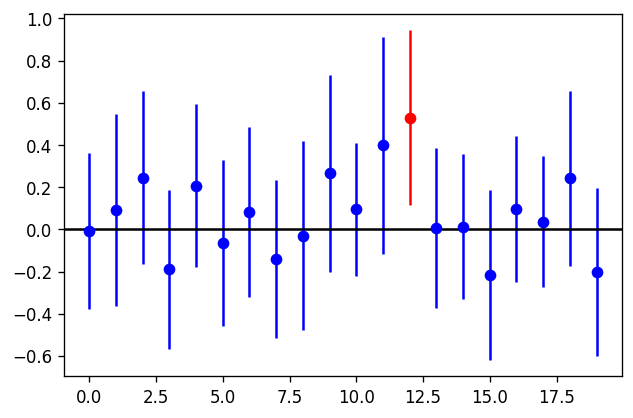

In [3]:
def ci_simulation():
    # Set the random seed to always get the same random numbers. 
    # This is for Reproducibility. 
    np.random.seed(4)
    
    # Create the figure.
    fig, ax = plt.subplots(dpi = 120)

    # If the interval crosses this line, it should be blue, else red.
    ax.axhline(0, color = 'k')

    # Do the following 20 times
    for i in range(20):

        #Draw 25 observations from a standard normal
        obs = np.random.normal(size=25)
        
        # Compute what we need for the CI, namely the mean and the bounds
        (mu, bounds) = confidence_interval(obs)
        
        # color should be blue if it crosses the black line
        color = 'blue'
        if (min(bounds)>0)|(max(bounds)<0):
            # but in the case it does not, turn it red
            color = 'red'

        # Need to get the length of the interval from bounds
        interval_len = 1.0/2*(bounds[1] - bounds[0])
        ax.errorbar(i, mu, yerr=interval_len, color = color, fmt = 'o')

    # This function does not have to return anything
    return None

ci_simulation()

### Question 3: /8pts

If you haven't changed the random seed from 4 and if you implemented the solution correctly, you should one red interval.

Answer the following below in no more than 3 sentences:

a) How many red intervals did we expect to see?  What is your justifiation for this?

Changing the random seed might affect how many red intervals you see.  Try changing the  random seed in your function to 3.  This will yield two red intervals (which is different than what you should expect to see). 

b) Why does the simulation sometimes deviate from the predicted results?


a) You would expect to see 1 red interval (rate of 0.05). This is because, by definition of confidence interval, 95% of randomly generated confidence intervals should contain the sample mean (in this case 0), thus only 5% shouldn't. 

b) A small "sample of samples" is not guaranteed to follow its parameters exactly. Like any distribution, it has its expected value, and it has its variance. As a result there is a probability that more or less than 5% of samples will not contain the true mean.

### Question 4: /10pts

Load in the `hockey_draftees_2005.csv` data into pandas. It contains data from hockey players drafted in 2005, including their rank, weight (wt - in pounds) and height (ht - in inches). 

Fit a linear model of weight (`wt`) explained by height (`ht`) using a linear regression model from sklearn, as done in the lab.  Call your fitted model `model`.  
Make a scatter plot of the height (x-axis) against weight (y-axis). 
Add the predicted values for 66-80 inches. 

Calculate the residuals from the fit, and report the r-squared for this model.

Training rsquared is  0.43807746842392215


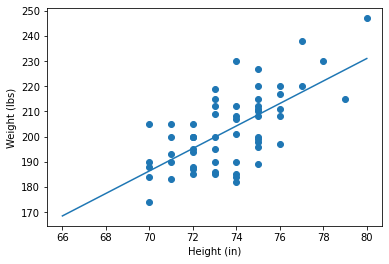

In [4]:
df=pd.read_csv("hockey_draftees_2005.csv")

# Make it and fit the model 
weight = df.wt
height = df.ht
X_height = np.c_[height]
model = sklearn.linear_model.LinearRegression().fit(X_height, weight)

# Make the scatter plot 
plt.scatter(height, weight)

#Generate and plot the predicted values
pred_domain = np.linspace(66,80,(80-66+1))
X_pred_domain = np.c_[pred_domain]
y_hat = model.predict(X_pred_domain)

plt.plot(pred_domain, y_hat)
plt.xlabel("Height (in)")
plt.ylabel("Weight (lbs)")

# Calculate residuals, R2 and print it
residuals = (model.predict(X_height) - weight)
rsquared = model.score(X_height, weight)

print('Training rsquared is ', rsquared)


### Question 5:  /15pts
### Bootstrap confidence intervals on parameters

How confident can we be about the relation between height and weight? 
To judge this we need confidence intervals let's use the bootstrap.

Modify the function `BootstrapCoef` from lab 04 - part 2 to conduct a boostrap analysis for this regression model; 

* `data`, which is a dataframe having columns 'weight' and 'height'
* `numboot` which is an integer denoting how many bootstrap replications to perform.

The function should return `theta`, a numpy array of regression coefficients of size (numboot, 2)

You can use `pd.DataFrame.sample` with `replace = True` to perform the resampling.  `bootstrap` should return:
params: a numpy array of size [numboot,numParams] of bootstraped parameter values. The parameters are the intercept value and the slope from the linear regression. 
Tip: Note that the intercept can be retrieved from model.intercept_, whereas all the other regression coefficients are stored in model.coef_. 

Here is the documentation for `pd.DataFrame.sample`: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

Then call the function to get 100 boostrap samples for your linear regression model of wt explained by height. 
Make a joint scatter plot of the parameter value for the intercept and for the slope. 
Written answer: What do you notice? Why do you think the estimate for the intercept has such a high negative correlation with the slope? 

'Written answer: I think the estimate for the intercept has a high negative correlation with the slope because the higher the intercept, the less slope is necessary to be in the correct neighbourhood.\nFor example, if the slope stayed the same as the intercept rose, high predicted intercepts would be much more inaccurate.'

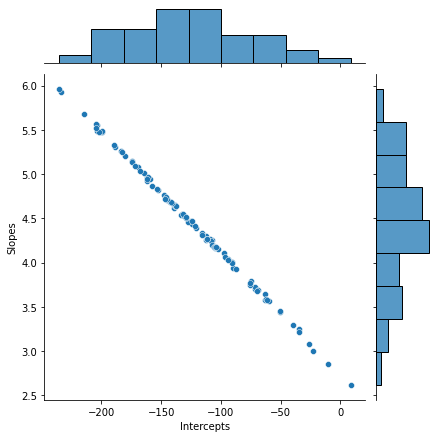

In [5]:
# Write a Bootstrap function that records the fitted models 
def BootstrapCoef(data,numboot=1000):
    n = len(data)
    theta = np.zeros((numboot, 2))
    regr = sklearn.linear_model.LinearRegression()
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_boot = np.c_[d.ht]
        regr.fit(X_boot, d.wt)
        theta[i,:]=[regr.intercept_,regr.coef_]
    return theta

data = df
numboot = 100
theta = BootstrapCoef(data, numboot)
sns.jointplot(x=theta[:,0], y=theta[:,1]).set_axis_labels("Intercepts", "Slopes")

'''Written answer: I think the estimate for the intercept has a high negative correlation with the slope because the higher the intercept, the less slope is necessary to be in the correct neighbourhood.
For example, if the slope stayed the same as the intercept rose, high predicted intercepts would be much more inaccurate.'''



Intercept and slope regressors are highly colinear - as we did not subtract the mean of ht before thre regression. 

### Question 6: /12pts

Plot the bootstrap estimates for the slope as a histogram.  Use your samples to compute a 95% confidence interval. Note that the CI should be constructed around the sample estimate of the slope. How can you interpret this confindence interval?  

My confidence interval is between 4.312536503467738  and  4.594561746357529


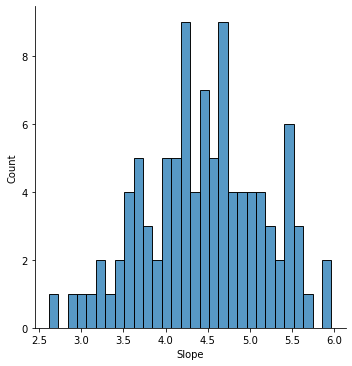

In [6]:
# Calculate bootstrap interval

# Getting just the slope estimates, retrieving their CI intervals
slope_estimates = theta[:,1]
boot_ci = confidence_interval(slope_estimates)[1]

# Plotting the different slope estimates as a histogram
sns.displot(slope_estimates, bins=30).set(xlabel="Slope")



print('My confidence interval is between', boot_ci[0], ' and ', boot_ci[1])

Written answer: The interval contains the true slope parameter with a probability of 95%. 

### Question 7: /15pts
Modify the function `BootstrapPred` from lab04 to bootstrap your fit and generate a predict from each of these bootstrapped models.  

Draw again a scatter plot of height against weight and plot the predictions from the 20 fitted bootstrap models for the height ranging from 60 to 88. 

Written answer: Where are we most uncertain in our prediction about the weight of a player? How does the negative correlation between slope and intercept play a role here?  Why is the spread of the prediction in the mean weight so much lower than the variability of our intercept parameter? 

Text(0, 0.5, 'Weight (lbs)')

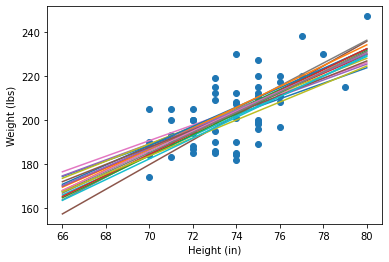

In [7]:
# BootstrapPred Model
def BootstrapPred(data, xp):
    numboot = 100
    n = len(data)
    X_pred = xp
    y_pred = np.zeros((numboot, xp.shape[0]))
    regr = sklearn.linear_model.LinearRegression()
    for i in range(numboot):
        d = data.sample(n, replace=True)
        X_boot = np.c_[d.ht]
        regr.fit(X_boot, d.wt)
        y_pred[i,:]=regr.predict(X_pred)
    return y_pred

data = df
xp = X_pred_domain
y_pred = BootstrapPred(data, xp)

plt.scatter(height, weight)
for i in range(20):
    plt.plot(xp, y_pred[i,:])
plt.xlabel("Height (in)")
plt.ylabel("Weight (lbs)")



The greatest uncertainty we have for the very small and very tall players. All lines agree in their prediction for the players of middle weight. For the lines to cross in the middle of the graph, a large slope needs to have a small intercept and a small slope needs to have a large intercept. 

### Question 8:  /15pts

Now, let's see how well our model performs out of sample.  Load in the `hockey_draftees_test.csv` file into a dataframe.  
Use your fitted `model` to make predictions. 

Make a scatter plot of the test data and superimpose the prediction of the model. 
To evaluate this prediction, calculate the r-square value for the out of sample (oos) data.  Statsmodels doesn't provide a function to compute r-squared on new data.  You will have to write one yourself or find one that performs the computation for you.

Out of sample rsquared is  -0.015001136144207727


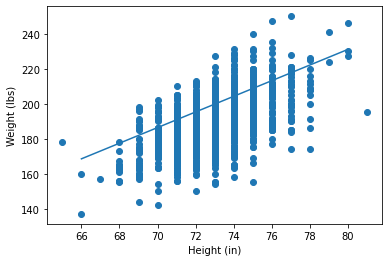

In [8]:
df_test=pd.read_csv('hockey_draftees_test.csv')

# R2 calculator
def r2(y, y_hat):
    # Getting TSS
    tss = y - np.mean(y)
    tss = tss * tss
    tss = np.sum(tss)
    
    # Getting RSS
    res = y - y_hat
    rss = np.sum(res * res)
    
    
    r_2 = 1-(rss/tss)
    return r_2

# Make the scatter plot
plt.scatter(df_test.ht, df_test.wt)

# Generate and plot the predicted values
y_pred = model.predict(X_pred_domain)
plt.plot(X_pred_domain, y_pred)
plt.xlabel("Height (in)")
plt.ylabel("Weight (lbs)")

# Now do the prediction for the test data and compute R2
X_test = np.c_[df_test.ht]
y_hat = model.predict(X_test)
y_test = df_test.wt
rsquared_oos = r2(y_test, y_hat)

print('Out of sample rsquared is ', rsquared_oos)
